In [ ]:
from io import IncrementalNewlineDecoder
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
dataset= pd.read_csv("/content/flightdata.csv")
dataset.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7426 entries, 0 to 7425
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 7426 non-null   int64  
 1   QUARTER              7426 non-null   int64  
 2   MONTH                7426 non-null   int64  
 3   DAY_OF_MONTH         7426 non-null   int64  
 4   DAY_OF_WEEK          7426 non-null   int64  
 5   UNIQUE_CARRIER       7426 non-null   object 
 6   TAIL_NUM             7426 non-null   object 
 7   FL_NUM               7426 non-null   int64  
 8   ORIGIN_AIRPORT_ID    7426 non-null   int64  
 9   ORIGIN               7426 non-null   object 
 10  DEST_AIRPORT_ID      7426 non-null   int64  
 11  DEST                 7426 non-null   object 
 12  CRS_DEP_TIME         7426 non-null   int64  
 13  DEP_TIME             7323 non-null   float64
 14  DEP_DELAY            7323 non-null   float64
 15  DEP_DEL15            7323 non-null   f

In [ ]:
dataset = dataset.drop('Unnamed: 25', axis=1)
dataset.isnull().sum()


YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               103
DEP_DELAY              103
DEP_DEL15              103
CRS_ARR_TIME             0
ARR_TIME               110
ARR_DELAY              166
ARR_DEL15              166
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         1
ACTUAL_ELAPSED_TIME    167
DISTANCE                 1
dtype: int64

In [ ]:
#filter the dataset to eliminate columns that aren't relevant to a predictive model.
dataset = dataset[["FL_NUM", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN",  "DEST", "CRS_ARR_TIME","DEP_DEL15", "ARR_DEL15"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DEL15       103
ARR_DEL15       166
dtype: int64

In [ ]:
dataset[dataset.isnull().any(axis=1)].head(10)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,NaN
179,86,1,10,7,MSP,DTW,1632,NaN,NaN
184,557,1,10,7,MSP,DTW,912,0.0,NaN
210,1096,1,10,7,DTW,MSP,1303,NaN,NaN
478,1542,1,22,5,SEA,JFK,723,NaN,NaN
481,1795,1,22,5,ATL,JFK,2014,NaN,NaN
491,2312,1,22,5,MSP,JFK,2149,NaN,NaN
499,423,1,23,6,JFK,ATL,1600,NaN,NaN
500,425,1,23,6,JFK,ATL,1827,NaN,NaN
501,427,1,23,6,JFK,SEA,1053,NaN,NaN


In [ ]:
dataset['DEP_DEL15'].mode()

0    0.0
Name: DEP_DEL15, dtype: float64

In [ ]:
#replace the missing values with 1s.
dataset = dataset.fillna({'ARR_DEL15': 1})
dataset = dataset.fillna({'DEP_DEL15': 0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,1.0
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,1.0
180,87,1,10,7,DTW,MSP,1649,1.0,0.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0
184,557,1,10,7,MSP,DTW,912,0.0,1.0


In [ ]:
import math
for index, row in dataset.iterrows():
    dataset.loc[index, 'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
dataset.head()    

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,ATL,SEA,21,0.0,0.0
1,1476,1,1,5,DTW,MSP,14,0.0,0.0
2,1597,1,1,5,ATL,SEA,12,0.0,0.0
3,1768,1,1,5,SEA,MSP,13,0.0,0.0
4,1823,1,1,5,SEA,DTW,6,0.0,0.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset[ 'DEST'] = le.fit_transform(dataset[ 'DEST'])
dataset['ORIGIN'] = le.fit_transform(dataset[ 'ORIGIN'])


In [ ]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,0,4,21,0.0,0.0
1,1476,1,1,5,1,3,14,0.0,0.0
2,1597,1,1,5,0,4,12,0.0,0.0
3,1768,1,1,5,4,3,13,0.0,0.0
4,1823,1,1,5,4,1,6,0.0,0.0


In [ ]:
dataset['ORIGIN'].unique()


array([0, 1, 4, 3, 2])

In [ ]:
dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,21,0.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,14,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,12,0.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,13,0.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,6,0.0,0.0,0,0,0,0,1,0,1,0,0,0


In [ ]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [ ]:
x

array([[1.399e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.476e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.597e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.866e+03, 8.000e+00, 2.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.995e+03, 8.000e+00, 2.900e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.032e+03, 8.000e+00, 2.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()
#x=np.delete(x,[4,7],axis=1)

In [ ]:
z

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
t

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
x=np.delete(x,[4,5],axis=1)

In [ ]:
dataset.describe()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
count,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000
mean,1334.325617,6.628973,15.790758,3.960199,15.067314,0.141483,0.139168,0.276022,0.195975,0.122340,0.225982,0.179681,0.286795,0.196866,0.116820,0.221975,0.177544
std,811.875227,3.354678,8.782056,1.995257,5.023534,0.348535,0.346138,0.447048,0.396967,0.327693,0.418246,0.383939,0.452285,0.397648,0.321219,0.415593,0.382146
min,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,624.000000,4.000000,8.000000,2.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1267.000000,7.000000,16.000000,4.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2032.000000,9.000000,23.000000,6.000000,19.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2853.000000,12.000000,31.000000,7.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<ipython-input-22-43f5c122a6ef>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.MONTH)


<Axes: xlabel='MONTH', ylabel='Density'>

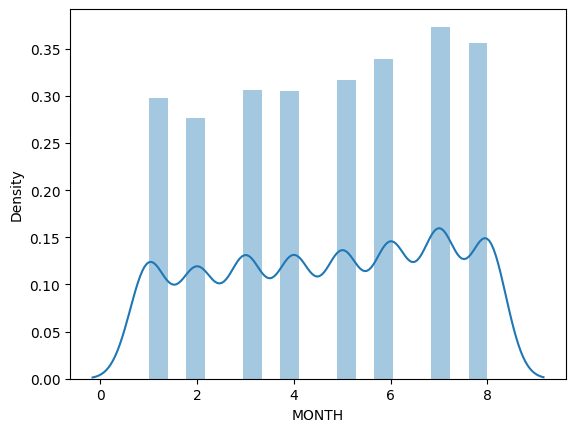

In [ ]:
sns.distplot(dataset.MONTH)

<Axes: >

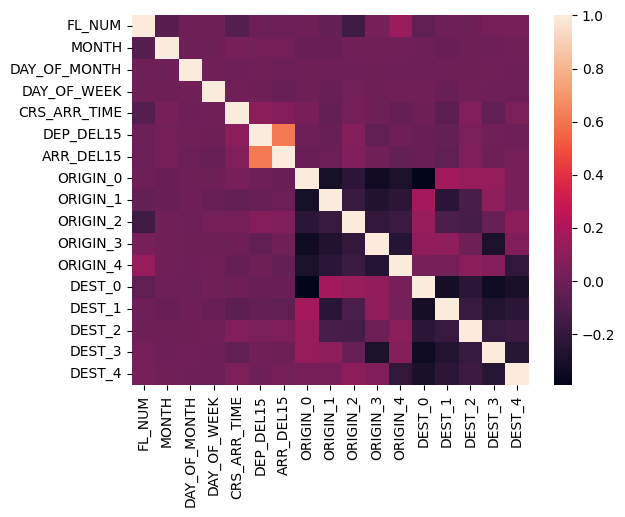

In [ ]:
sns.heatmap(dataset.corr())

<Axes: xlabel='DEP_DEL15', ylabel='ARR_DEL15'>

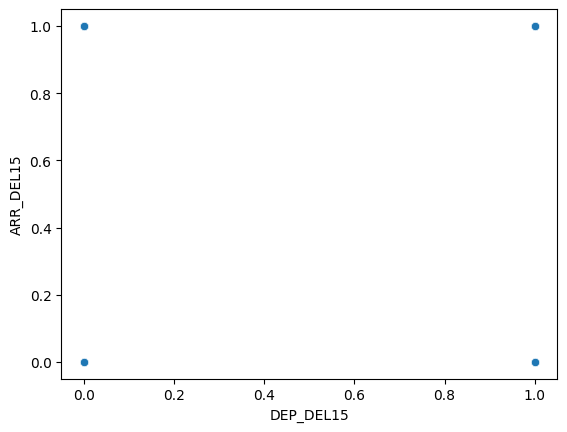

In [ ]:
sns.scatterplot(x='DEP_DEL15',y='ARR_DEL15',data=dataset)

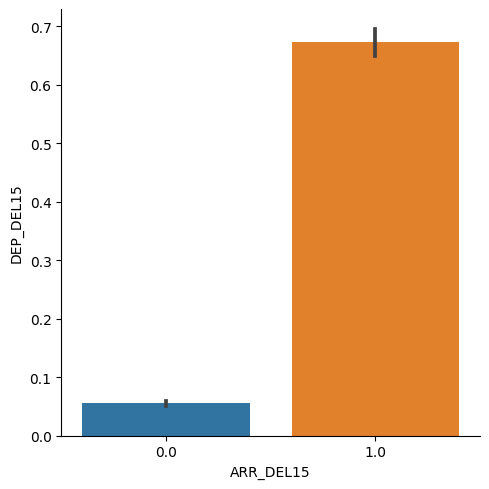

In [ ]:
sns.catplot(x="ARR_DEL15",y="DEP_DEL15",kind='bar',data=dataset)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(dataset.drop('ARR_DEL15', axis=1), dataset['ARR_DEL15'], test_size=0.2, random_state=0)

In [ ]:
x_test.shape

(2247, 16)

In [ ]:
x_train.shape

(8984, 16)

In [ ]:
y_test.shape

(2247,)

In [ ]:
y_train.shape

(8984,)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
decisiontree = classifier.predict(x_test)

In [ ]:
decisiontree

array([1., 0., 0., ..., 0., 0., 1.])

In [ ]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy')

In [ ]:
rfc.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [ ]:
y_predict = rfc.predict(x_test)

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
classification = Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))

In [ ]:
classification.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=100)

Epoch 1/100
1797/1797 [==============================] - 8s 3ms/step - loss: 0.2894 - accuracy: 0.8988 - val_loss: 0.2746 - val_accuracy: 0.9076
Epoch 2/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.2689 - accuracy: 0.9040 - val_loss: 0.2755 - val_accuracy: 0.9054
Epoch 3/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.2649 - accuracy: 0.9047 - val_loss: 0.2695 - val_accuracy: 0.9071
Epoch 4/100
1797/1797 [==============================] - 6s 4ms/step - loss: 0.2635 - accuracy: 0.9069 - val_loss: 0.2684 - val_accuracy: 0.9060
Epoch 5/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.2594 - accuracy: 0.9078 - val_loss: 0.2733 - val_accuracy: 0.9015
Epoch 6/100
1797/1797 [==============================] - 7s 4ms/step - loss: 0.2589 - accuracy: 0.9066 - val_loss: 0.2731 - val_accuracy: 0.9071
Epoch 7/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.2561 - accuracy: 0.9080 - val_loss: 0.2753 - val_ac

In [ ]:
y_pred = classifier.predict([[129,99,1,0,0,1,0,1,1,1,0,1,1,1,1,1]])
print(y_pred)
(y_pred)

[1.]


array([1.])

In [ ]:
y_pred = rfc.predict([[129,99,1,0,0,1,0,1,1,1,0,1,1,1,1,1]])

print(y_pred)
(y_pred)

[0.]


array([0.])

In [ ]:
classification.save('flight.h5')

In [ ]:
y_pred = classification.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [ ]:
y_pred

array([[1.2181829e-24],
       [1.0000000e+00],
       [1.3072760e-20],
       ...,
       [1.0099473e-02],
       [1.9690395e-18],
       [9.9999952e-01]], dtype=float32)

In [ ]:
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
def predict_exit(sample_value):
 sample_value = np.array(sample_value)
 sample_value = sample_value.reshape(1, -1)
 sample_value = sc.transform(sample_value)
 return classifier.predict(sample_value)

In [ ]:
test=classification.predict([[1,1,121.000000,36.0,0,0,1,0,1,1,1,1,1,1,1,1]])
if test==1:
    print('prediction: Chance of delay')
else:
    print('prediction: No chance of delay.')    

1/1 [==============================] - 0s 67ms/step
prediction: No chance of delay.


In [ ]:
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

In [ ]:
    dfs = [] 
models = [
           ('RF', RandomForestClassfier()),
           ('DecisionTree',DecisionTreeClassifier()),
           ('ANN',MLPClassifier())
        ]
results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['no delay', 'delay']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, x_train, y_train, cv=kfold, scoring=scoring) 
        clf = model.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name 
        dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)
return final                

NameError: ignored

In [ ]:
print('Training accuracy: ',accuracy_score(y_train,y_predict_train))
print('Testing accuracy: ',accuracy_score(y_test,y_predict))


NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
cm

In [ ]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)


In [ ]:
desacc

0.8600269179004038

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,decisiontree)

In [ ]:
cm

In [ ]:
from sklearn.metrics import accuracy_score,classification_report
score = accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is: {}%'.format(score*100))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
parameters = {
                'n_estimators' : [1,20,30,55,68,74,90,120,115],
                 'criterion':['gini','entropy'],
                'max_features' : ["auto", "sqrt", "log2"],
        'max_depth' : [2,5,8,10], 'verbose' : [1,2,3,4,6,8,9,10]
}           

In [ ]:
RCV = RandomizedSearchCV(estimator=rf,param_distributions=parameters,cv=10,n_iter=4)

In [ ]:
RCV.fit(x_train,y_train)

ValueError: ignored

In [ ]:
bt_params = RCV.best_params_
bt_score = RCV.best_score_


AttributeError: ignored

In [ ]:
bt_params

In [ ]:
bt_score

In [ ]:
model = RandomForestClassifier(verbose= 10, n_estimators= 120, max_features= 'log2',max_depth= 10,criterison= 'entropy')
RCV.fit(x_train,y_train)

In [ ]:
y_predict_rf = RCV.predict(x_test)

In [ ]:
RFC=accuracy_score(y_test,y_predict_rf)
RFC

In [ ]:
import pickle
pickle.dump(RCV,open('flight.pkl','wb'))

In [ ]:
from flask import Flask,request,render_template
import numpy as np
import pandas as pd
import pickle
import os

In [ ]:
model = pickle.load(open('filght.pkl','rb'))
app = Flask(_name_)

In [ ]:
@app.route('/')
def home():
    return render_template("index.html")
@app.route('/prediiction',methods=['POST'])    

In [ ]:
def predict():
    name = request.form['name']
    month = request.form['month']
    dayofmonth = request.form['dayofmonth']
    dayofweek = request.form['dayofweek']
    origin = request.form['origin']
    if(origin == "msp"):
        origin1,origin2,origin3,origin4,origin5 = 0,0,0,0,1
    if(origin == "dtw"):
        origin1,origin2,origin3,origin4,origin5 = 1,0,0,0,0
    if(origin == "jfk"):
        origin1,origin2,origin3,origin4,origin5 = 0,0,1,0,0
    if(origin == "sea"):
        origin1,origin2,origin3,origin4,origin5 = 0,1,0,0,0
    if(origin == "alt"):
        origin1,origin2,origin3,origin4,origin5 = 0,0,0,1,0                

In [ ]:
destination = request.form['destination']
if(destination == "msp"):
     destination1,destination2,destination3,destination4,destination5 = 0,0,0,0,1
if(destination == "dtw"):
     destination1,destination2,destination3,destination4,destination5 = 1,0,0,0,0
if(destination == "jfk"):
     destination1,destination2,destination3,destination4,destination5 = 0,0,1,0,0
 if(destination == "sea"):
     destination1,destination2,destination3,destination4,destination5 = 0,1,0,0,0
if(destination == "alt"):
     destination1,destination2,destination3,destination4,destination5 = 0,0,0,1,0
dep = request.form['dept']
arrtime = request.form['arrtime']
dept15=int(dept)-int(actdept)
total = [[name,month,dayofmonth,dayofweek,origin1,origin2,origin3,origin4,origin5,destination1,destination2,destination3,destination4,destination5]]
y_pred = model.predict(total)
print(y_pred) 
if(y_pred==[0.]):
    ans="The Flight Will be on time" 
else:
    ans="The Flight Will be delayed" 
return render_template("index.html",showcase = ans)                             

In [ ]:
if __name__ == '__main__':
  app.run(debug = True)